In [ ]:
### Домашнее задание

- Обучите нейронную сеть на датасете indoor-outdoor и оцените её качество (3 балла)
- Для обучения введите автоматическое разбиение на train/val в пропорции 70/30 (0.5 балла)
- Постройте графики метрик качества (1 балл)
- Попробуйте поменять гиперпараметры и сделать выводы о том, как это влияет на качество (0.5 балла). 

### По желанию (*но всячески приветствуется*)
- Попробуйте вычислить F1-меру и построить confusion matrix
- При разбиение на train/val сравните результаты со стратификацией и без нее

*Цель:* выработать навык обучения нейронных сетей (в частности сверточных) на основе средств PyTorch, начиная от загрузки датасетами и заканчивая выводами результатов, их логгированием, сравнением и анализом.

In [2]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split

from tqdm import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cuda')

In [5]:
train_dir = "/kaggle/input/indooroutdoordataset/train/"

In [6]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [7]:
data = datasets.ImageFolder(train_dir, transform=train_transforms)

In [8]:
train_split_param = 0.7

In [9]:
train_size = int(train_split_param * len(data))
test_size = len(data) - train_size

train_data, test_data = random_split(data, [train_size, test_size])

In [10]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 2079
Number of testing examples: 891


In [11]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=True)

In [12]:
model = models.resnet18(pretrained=True)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
model.fc = nn.Linear(model.fc.in_features, 3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 186MB/s]


In [40]:
def train(model, optimizer, n_epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    accuracies, losses = [], []
    for epoch in range(n_epochs):
        
        # обучение
        for x_train, y_train in tqdm(train_dataloader):
            x_train = x_train.to(device)
            y_train = y_train.to(device)
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # валидация
        test_loss = []
        test_accuracy = []
        with torch.no_grad():
            for x_val, y_val in tqdm(test_dataloader):
                x_val = x_val.to(device)
                y_val = y_val.to(device)
                y_pred = model(x_val).to(device)
                loss = F.cross_entropy(y_pred, y_val)
                test_loss.append(loss.cpu().numpy())
                test_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).cpu().numpy().tolist())

        accuracies.append(np.mean(test_accuracy))
        losses.append(np.mean(test_loss))
        print(f'Epoch: {epoch}, loss: {np.mean(test_loss)}, accuracy: {np.mean(test_accuracy)}')
    return accuracies, losses


def plot_metrics(metric, caption):
    plt.figure(figsize=(7,4))
    plt.plot(list(range(0, len(metric))), metric)
    plt.title(f'Зависимость кол-ва эпох от значения {caption}', fontsize=16)
    plt.grid()


def predict(model, dataloader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    preds, tests = [], []
    with torch.no_grad():
        for x_test, y_test in tqdm(dataloader):
            x_test = x_test.to(device)
            y_test = y_test.to(device)
            y_pred = model(x_test).to(device)
            preds.extend(torch.argmax(y_pred, dim=-1).cpu().numpy())
            tests.extend(y_test.cpu().numpy())
    print(f"F1 Score: {f1_score(tests, preds, average='weighted')}")
    cm = confusion_matrix(tests, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["GT", "dcp", "hazy"])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"Confusion Matrix")
    plt.show()
    return preds

In [14]:
accs, losses = train(model, optimizer)

100%|██████████| 7/7 [00:24<00:00,  3.53s/it]


Epoch: 0, loss: 0.7871128916740417, accuracy: 0.6879910213243546


100%|██████████| 7/7 [00:17<00:00,  2.51s/it]


Epoch: 1, loss: 0.5712029337882996, accuracy: 0.8181818181818182


100%|██████████| 7/7 [00:17<00:00,  2.57s/it]


Epoch: 2, loss: 0.4535442292690277, accuracy: 0.8664421997755332


100%|██████████| 7/7 [00:17<00:00,  2.54s/it]


Epoch: 3, loss: 0.3739464581012726, accuracy: 0.8888888888888888


100%|██████████| 7/7 [00:17<00:00,  2.48s/it]


Epoch: 4, loss: 0.3151922821998596, accuracy: 0.9124579124579124


100%|██████████| 7/7 [00:17<00:00,  2.49s/it]


Epoch: 5, loss: 0.27417275309562683, accuracy: 0.9124579124579124


100%|██████████| 7/7 [00:17<00:00,  2.54s/it]


Epoch: 6, loss: 0.24638451635837555, accuracy: 0.9292929292929293


100%|██████████| 7/7 [00:17<00:00,  2.49s/it]


Epoch: 7, loss: 0.2362823784351349, accuracy: 0.9158249158249159


100%|██████████| 7/7 [00:17<00:00,  2.45s/it]


Epoch: 8, loss: 0.2171870321035385, accuracy: 0.9304152637485971


100%|██████████| 7/7 [00:17<00:00,  2.51s/it]

Epoch: 9, loss: 0.19800806045532227, accuracy: 0.9371492704826038


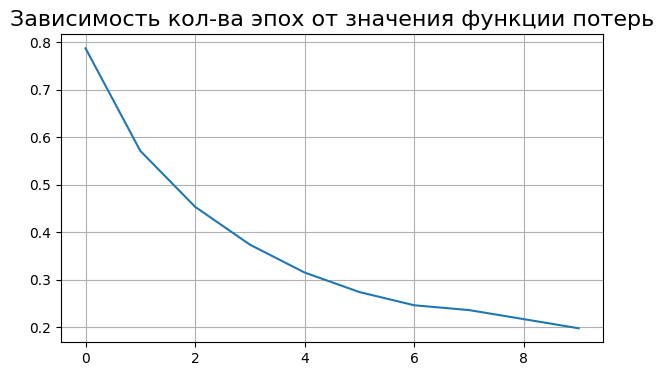

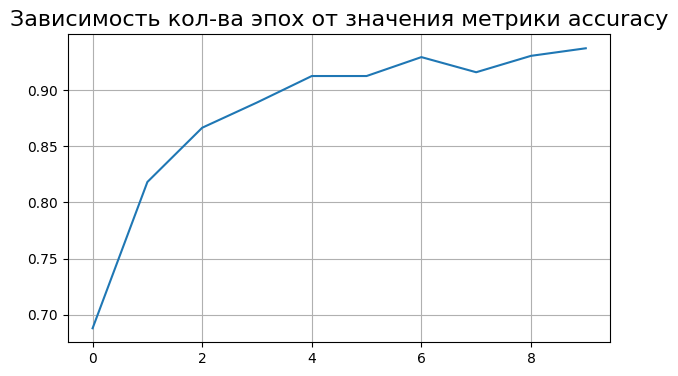

In [15]:
plot_metrics(losses, 'функции потерь')
plot_metrics(accs, 'метрики accuracy')

100%|██████████| 7/7 [00:18<00:00,  2.57s/it]

F1 Score: 0.9361993643886289


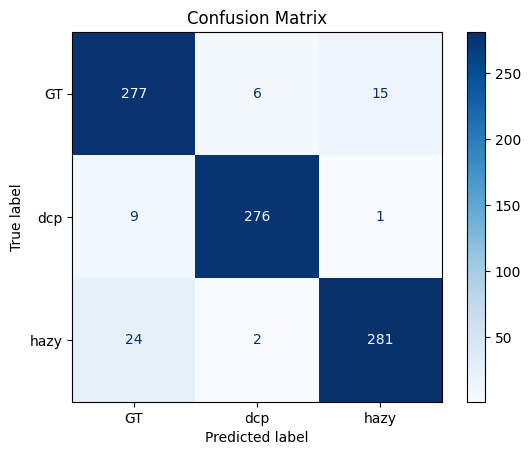

In [28]:
preds = predict(model, test_dataloader)

In [29]:
model = models.resnet18(pretrained=True)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
model.fc = nn.Linear(model.fc.in_features, 3)

In [30]:
accs, losses = train(model, optimizer)

100%|██████████| 7/7 [00:17<00:00,  2.51s/it]


Epoch: 0, loss: 0.20333001017570496, accuracy: 0.9270482603815937


100%|██████████| 7/7 [00:17<00:00,  2.50s/it]


Epoch: 1, loss: 0.151727095246315, accuracy: 0.9461279461279462


100%|██████████| 7/7 [00:17<00:00,  2.52s/it]


Epoch: 2, loss: 0.32559654116630554, accuracy: 0.8731762065095399


100%|██████████| 7/7 [00:17<00:00,  2.51s/it]


Epoch: 3, loss: 0.14333848655223846, accuracy: 0.9494949494949495


100%|██████████| 7/7 [00:17<00:00,  2.47s/it]


Epoch: 4, loss: 0.1607164442539215, accuracy: 0.9461279461279462


100%|██████████| 7/7 [00:17<00:00,  2.49s/it]


Epoch: 5, loss: 0.13708390295505524, accuracy: 0.9494949494949495


100%|██████████| 7/7 [00:17<00:00,  2.44s/it]


Epoch: 6, loss: 0.5882979035377502, accuracy: 0.8159371492704826


100%|██████████| 7/7 [00:17<00:00,  2.50s/it]


Epoch: 7, loss: 0.134284108877182, accuracy: 0.9528619528619529


100%|██████████| 7/7 [00:17<00:00,  2.48s/it]


Epoch: 8, loss: 0.14496324956417084, accuracy: 0.9494949494949495


100%|██████████| 7/7 [00:17<00:00,  2.48s/it]

Epoch: 9, loss: 0.12035594135522842, accuracy: 0.957351290684624


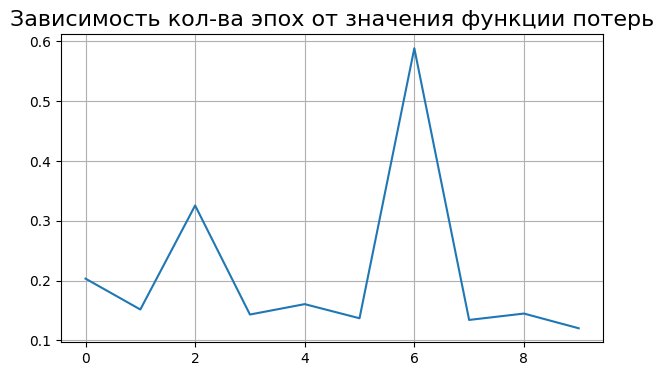

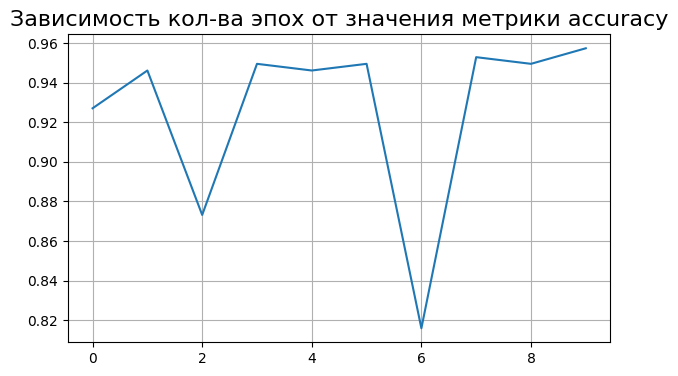

In [31]:
plot_metrics(losses, 'функции потерь')
plot_metrics(accs, 'метрики accuracy')

100%|██████████| 7/7 [00:17<00:00,  2.46s/it]


F1 Score: 0.9620053458274547


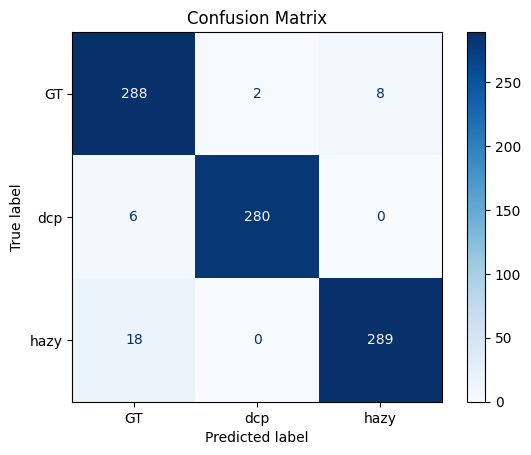

In [32]:
preds = predict(model, test_dataloader)

In [33]:
model = models.resnet18(pretrained=True)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
model.fc = nn.Linear(model.fc.in_features, 3)

In [34]:
accs, losses = train(model, optimizer, n_epochs=20)

100%|██████████| 7/7 [00:17<00:00,  2.46s/it]


Epoch: 0, loss: 0.19882631301879883, accuracy: 0.9337822671156004


100%|██████████| 7/7 [00:17<00:00,  2.49s/it]


Epoch: 1, loss: 0.24288427829742432, accuracy: 0.898989898989899


100%|██████████| 7/7 [00:17<00:00,  2.48s/it]


Epoch: 2, loss: 0.12159086763858795, accuracy: 0.9562289562289562


100%|██████████| 7/7 [00:17<00:00,  2.50s/it]


Epoch: 3, loss: 0.14917676150798798, accuracy: 0.9461279461279462


100%|██████████| 7/7 [00:17<00:00,  2.52s/it]


Epoch: 4, loss: 0.11829345673322678, accuracy: 0.957351290684624


100%|██████████| 7/7 [00:17<00:00,  2.52s/it]


Epoch: 5, loss: 0.1114036962389946, accuracy: 0.957351290684624


100%|██████████| 7/7 [00:17<00:00,  2.50s/it]


Epoch: 6, loss: 0.11837106198072433, accuracy: 0.9562289562289562


100%|██████████| 7/7 [00:17<00:00,  2.46s/it]


Epoch: 7, loss: 0.12167423218488693, accuracy: 0.957351290684624


100%|██████████| 7/7 [00:17<00:00,  2.49s/it]


Epoch: 8, loss: 0.1228628158569336, accuracy: 0.9562289562289562


100%|██████████| 7/7 [00:17<00:00,  2.45s/it]


Epoch: 9, loss: 0.1211531013250351, accuracy: 0.9584736251402918


100%|██████████| 7/7 [00:17<00:00,  2.48s/it]


Epoch: 10, loss: 0.13253696262836456, accuracy: 0.9539842873176206


100%|██████████| 7/7 [00:17<00:00,  2.54s/it]


Epoch: 11, loss: 0.11486734449863434, accuracy: 0.957351290684624


100%|██████████| 7/7 [00:17<00:00,  2.48s/it]


Epoch: 12, loss: 0.11586904525756836, accuracy: 0.957351290684624


100%|██████████| 7/7 [00:17<00:00,  2.50s/it]


Epoch: 13, loss: 0.1154409795999527, accuracy: 0.9629629629629629


100%|██████████| 7/7 [00:17<00:00,  2.50s/it]


Epoch: 14, loss: 0.11302993446588516, accuracy: 0.9584736251402918


100%|██████████| 7/7 [00:17<00:00,  2.52s/it]


Epoch: 15, loss: 0.11787581443786621, accuracy: 0.9562289562289562


100%|██████████| 7/7 [00:17<00:00,  2.53s/it]


Epoch: 16, loss: 0.11163084208965302, accuracy: 0.9618406285072951


100%|██████████| 7/7 [00:17<00:00,  2.45s/it]


Epoch: 17, loss: 0.11531848460435867, accuracy: 0.9652076318742986


100%|██████████| 7/7 [00:17<00:00,  2.50s/it]


Epoch: 18, loss: 0.11086873710155487, accuracy: 0.957351290684624


100%|██████████| 7/7 [00:17<00:00,  2.51s/it]

Epoch: 19, loss: 0.13285312056541443, accuracy: 0.9528619528619529


100%|██████████| 7/7 [00:17<00:00,  2.54s/it]


F1 Score: 0.954215321159368


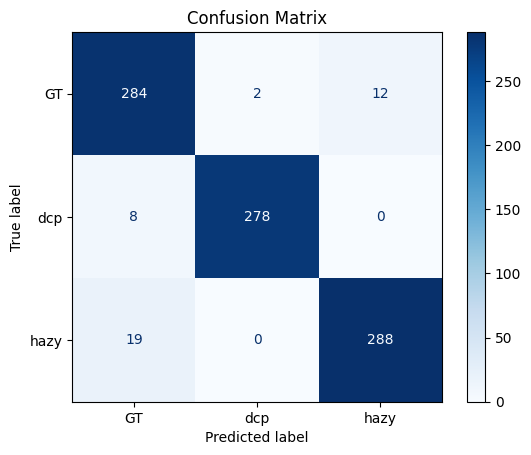

In [35]:
preds = predict(model, test_dataloader)

In [36]:
model = models.resnet18(pretrained=True)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
model.fc = nn.Linear(model.fc.in_features, 3)

In [37]:
accs, losses = train(model, optimizer, n_epochs=20)

100%|██████████| 7/7 [00:17<00:00,  2.53s/it]


Epoch: 0, loss: 0.8456416726112366, accuracy: 0.6071829405162739


100%|██████████| 7/7 [00:17<00:00,  2.50s/it]


Epoch: 1, loss: 0.6038644909858704, accuracy: 0.7867564534231201


100%|██████████| 7/7 [00:17<00:00,  2.54s/it]


Epoch: 2, loss: 0.4551140367984772, accuracy: 0.8597081930415263


100%|██████████| 7/7 [00:17<00:00,  2.48s/it]


Epoch: 3, loss: 0.37205252051353455, accuracy: 0.8911335578002245


100%|██████████| 7/7 [00:17<00:00,  2.45s/it]


Epoch: 4, loss: 0.32438579201698303, accuracy: 0.9057239057239057


100%|██████████| 7/7 [00:17<00:00,  2.46s/it]


Epoch: 5, loss: 0.27842992544174194, accuracy: 0.9135802469135802


100%|██████████| 7/7 [00:17<00:00,  2.47s/it]


Epoch: 6, loss: 0.25490131974220276, accuracy: 0.9180695847362514


100%|██████████| 7/7 [00:17<00:00,  2.47s/it]


Epoch: 7, loss: 0.23761440813541412, accuracy: 0.920314253647587


100%|██████████| 7/7 [00:17<00:00,  2.50s/it]


Epoch: 8, loss: 0.21624232828617096, accuracy: 0.9292929292929293


100%|██████████| 7/7 [00:17<00:00,  2.47s/it]


Epoch: 9, loss: 0.20581379532814026, accuracy: 0.9270482603815937


100%|██████████| 7/7 [00:17<00:00,  2.53s/it]


Epoch: 10, loss: 0.20778171718120575, accuracy: 0.9225589225589226


100%|██████████| 7/7 [00:17<00:00,  2.53s/it]


Epoch: 11, loss: 0.1874648779630661, accuracy: 0.9326599326599326


100%|██████████| 7/7 [00:17<00:00,  2.49s/it]


Epoch: 12, loss: 0.18224777281284332, accuracy: 0.9326599326599326


100%|██████████| 7/7 [00:17<00:00,  2.47s/it]


Epoch: 13, loss: 0.1794932335615158, accuracy: 0.9349046015712682


100%|██████████| 7/7 [00:17<00:00,  2.46s/it]


Epoch: 14, loss: 0.1705510914325714, accuracy: 0.9427609427609428


100%|██████████| 7/7 [00:17<00:00,  2.49s/it]


Epoch: 15, loss: 0.16610287129878998, accuracy: 0.9349046015712682


100%|██████████| 7/7 [00:17<00:00,  2.49s/it]


Epoch: 16, loss: 0.16294138133525848, accuracy: 0.9349046015712682


100%|██████████| 7/7 [00:17<00:00,  2.48s/it]


Epoch: 17, loss: 0.15093889832496643, accuracy: 0.9461279461279462


100%|██████████| 7/7 [00:17<00:00,  2.43s/it]


Epoch: 18, loss: 0.15161670744419098, accuracy: 0.9405162738496072


100%|██████████| 7/7 [00:17<00:00,  2.50s/it]

Epoch: 19, loss: 0.14862312376499176, accuracy: 0.9517396184062851


100%|██████████| 7/7 [00:17<00:00,  2.53s/it]


F1 Score: 0.9385309563547056


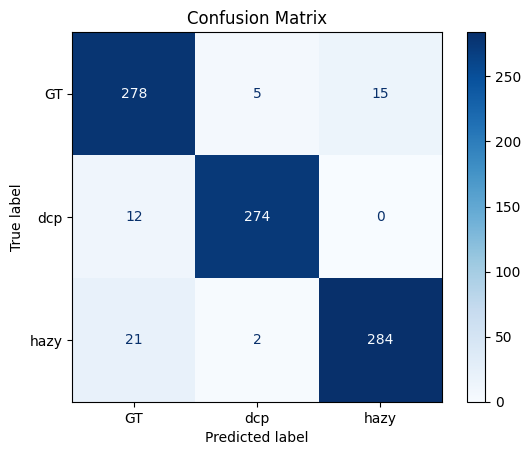

In [38]:
preds = predict(model, test_dataloader)

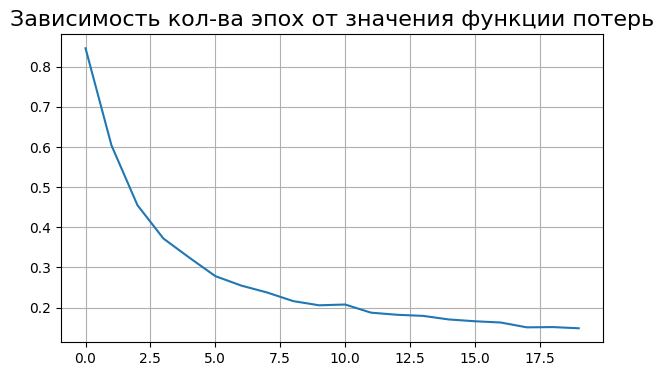

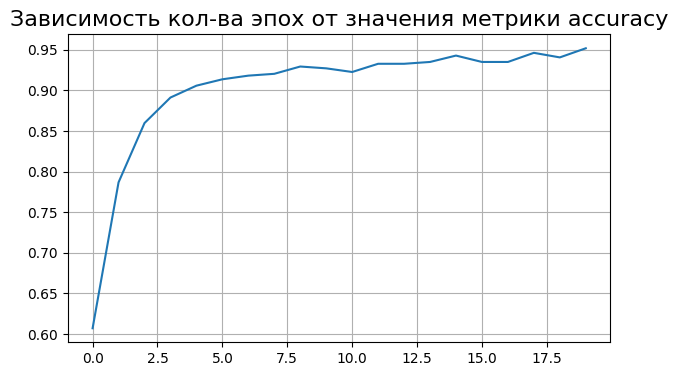

In [41]:
plot_metrics(losses, 'функции потерь')
plot_metrics(accs, 'метрики accuracy')

# Вывод

При увеличении lr модель не достигает минимума, а при увеличении числа эпох с 10 до 20 модель не показывает прироста по точности и после 8-10 эпохи начинает переобучаться, т.к. loss практически перестает изменяться